# Bag of Words Text Classification

In this assignment we will build a simple Bag of Words (BoW) text classifier using PyTorch. The classifier is trained on a Twitter dataset (with given labels) and is supposed to identify if the sentiment in individual tweets is *positive* or *negative*.


## Concepts covered in this assignment
1. NLP text pre-processing
2. Split of training, validation and testing datasets
3. Build a simple feed-forward neural net classifier using PyTorch
4. Training the model

As always, we start with some imports...




In [73]:
!pip install googledrivedownloader
!pip install torch

In [99]:
import random
import re # regular expression
from collections import Counter
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import google_drive_downloader
from google_drive_downloader import GoogleDriveDownloader as gdd
from IPython.core.display import display, HTML
from sklearn.metrics import classification_report
from tqdm import tqdm, tqdm_notebook # show progress bar

# PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

# nltk text processors
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

import pickle

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
plt.style.use('ggplot')
tqdm.pandas()

lemmatizer = WordNetLemmatizer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


device(type='cpu')

Next, we load our dataset.

In [75]:
DATA_PATH = 'data/twitter_reviews.csv'
if not Path(DATA_PATH).is_file():
    gdd.download_file_from_google_drive(
        file_id='13OLqDXOBAO9fjD9Shz8iTeev3ZaNHaTC',
        dest_path=DATA_PATH,
    )

df = pd.read_csv(DATA_PATH)

**Let's see what we are working with...**

In [76]:
print('Shape of the dataset' )
print(df.shape)

Shape of the dataset
(1000000, 3)


Below is a sample set of five random tweets and their classifications. The classifications are labeled "1" for positive and "0" for negative tweets.

In [77]:
df.sample(5)

,Unnamed: 0,tweet,label
395776,395776,"@Rhi133 I know, I personally was jumping for j...",1
250880,250880,@kaylizzz it breaks my heart that I can't date...,0
669399,669399,first night of packing. Don't feel like I got ...,0
528410,528410,@xleahmonroe i love you more,1
604071,604071,Can't sleep. I have the largest head ache righ...,0


Let's see the distribution of positive and negative tweets. This is the data our classifier will be trained on later.

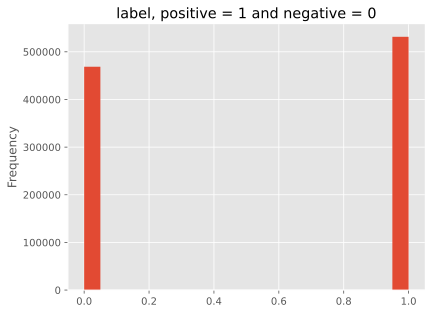

In [78]:
df['label'].plot(kind='hist', bins=20, title='label, positive = 1 and negative = 0')
#plt.gca().spines[['top', 'right',]].set_visible(False)

# Access the current axes using plt.gca() and set the visibility for each spine
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.show()

How about looking at specific examples for each class?

In [79]:
print('Example negative tweet:')
print(df.loc[55,].tweet, '\n')
print('Example positive tweet:')
print(df.loc[12456,].tweet, '\n')

Example negative tweet:
  David must be hospitalized for five days end of July (palatine tonsils). I will probably never see Katie in concert.  

Example positive tweet:
*sigh*  sweet dreams guys...... 



Looking at your data before starting to code will help you in the process for example when encountering errors, when the training does not improve, or when you simply want to understand your results in the end. Remember: a good DL model is only as good as the data we feed it with!

# 1. Preprocessing
(2.5 Points - 0.5 for each subtask)<br>

As in the last assignment, we need to transform our data before training our classifier on it. We are interested to do the following preprocessing steps:
* Replace weird characters
* Lowercase
* Tokenize
* Stemming & Lemmatize
* Remove stopwords

**Let's see how to pre-process these steps one by one. Below we constructed a simple test tweet.**

In [80]:
test_corpus = '''Curtain drops at the #Crown Uptown after 32 years http://www.kansas.com/news/featured/story/860875.html'''

<h1>Exercise 1.1</h1>
Write a function `special_and_lower` that removes special characters and puts the text lowercase. If you wonder what a special character is, check [here](https://www.computerhope.com/jargon/s/specchar.htm)


In [81]:
# Your answer goes here
def special_and_lower(test_corpus):
    """
    Remove special characters and convert text to lowercase.
    """
    # Remove special characters using regex
    processed_text = re.sub(r'[^a-zA-Z0-9\s]', '', test_corpus)

    # Convert to lowercase
    processed_text = processed_text.lower()

    return processed_text

#test_corpus = special_and_lower(test_corpus)
#print(test_corpus)

<h1>Exercise 1.2</h1>Write a function `tokenize_text` that creates a list of tokens from the input text. Use your own implementation here.

In [82]:
# Your answer goes here
"""def tokenize_text(test_corpus):
    # Tokenize sentences using NLTK
    sentences_strings_ted  = nltk.tokenize.sent_tokenize(test_corpus)

    # Word Tokenization and Preprocessing
    tokens = []  # List to store all tokens in the text

    # Loop through each sentence
    for sentence in sentences_strings_ted:
        # Word Tokenization
        words = nltk.tokenize.word_tokenize(sentence)

        # Remove Non-Letter Characters and Lowercasing
        words = [word.lower() for word in words if word.isalpha()]

        # Extend the tokens list with the words in the current sentence
        tokens.extend(words)

    return tokens"""

def tokenize_text(test_corpus):
    tokens = wordpunct_tokenize(test_corpus)
    return tokens



#test_corpus = tokenize_text(test_corpus)
#print(test_corpus)

In [83]:
#txt = "In the realm of artificial intelligence, transformer networks, a groundbreaking architecture introduced by Vaswani et al. in their seminal paper 'Attention is All You Need,' have revolutionized natural language processing, enabling parallelized and efficient learning through self-attention mechanisms, making them pivotal in various applications such as machine translation, sentiment analysis, and text generation, showcasing the power of attention-driven computations in capturing complex contextual relationships within vast datasets."
#print(tokenize_text(txt))

<h1>Exercise 1.3</h1>

Using  **WordNetLemmatizer** , write a function `lemmatize_text` that lemmatizes the text. Lemmatization, which is the process of grouping inflected forms together as a single base form, is a text normalization that is used in pre-processing. Please lemmatize first nouns and then verbs. For more information regarding *WordNetLemmatizer*, please check [here](https://www.nltk.org/_modules/nltk/stem/wordnet.html):


In [84]:
# Your answer goes here
def lemmatize_text(test_corpus, lemmatizer):
    """
    Lemmatize words in the test_corpus using WordNetLemmatizer.
    Each word is first lemmatized as a noun and then as a verb.
    :param test_corpus: List of words to lemmatize.
    :param lemmatizer: WordNetLemmatizer instance.
    :return: List of lemmatized words.
    """
    lemmatized_words = []
    for word in test_corpus:
        # First lemmatize as a noun
        lemma_noun = lemmatizer.lemmatize(word, pos='n')
        # Then lemmatize the result as a verb
        lemma_verb = lemmatizer.lemmatize(lemma_noun, pos='v')
        lemmatized_words.append(lemma_verb)

    return lemmatized_words

#lemmatizer = WordNetLemmatizer()
#test_corpus = lemmatize_text(test_corpus, lemmatizer)
#print(test_corpus)

In [85]:
#txt = nltk.tokenize.word_tokenize("In the realm of artificial intelligence, transformer networks, a groundbreaking architecture introduced by Vaswani et al. in their seminal paper 'Attention is All You Need,' have revolutionized natural language processing, enabling parallelized and efficient learning through self-attention mechanisms, making them pivotal in various applications such as machine translation, sentiment analysis, and text generation, showcasing the power of attention-driven computations in capturing complex contextual relationships within vast datasets.")
#print(lemmatize_text(txt, lemmatizer))

<h1>Exercise 1.4 </h1>Write a function `replace_numbers` that replaces any standalone number with the special token " < NUM > " (without the spaces). For instance, "42" must be replaced by the token but "42h" not.


In [86]:
# Your answer goes here
def replace_numbers(test_corpus):
    processed_text = []
    pattern = re.compile(r'\b\d+\b')
    for word in test_corpus:
        processed_text.append(pattern.sub('<NUM>', word))

    return processed_text

#test_corpus = replace_numbers(test_corpus)
#print(test_corpus)

<h1>Exercise 1.5</h1>We want to remove redundant words that are very common in all the texts (like "a" or "to"). As you learned previously, these words are called stopwords and do not contain any meaning, that is relevant for our task.
Write a function "remove_stopwords" that removes stopwords using the stopwords imported from NLTK (check on top).

In [87]:
# Your answer goes here
def remove_stopwords(test_corpus, stop_words):
    # Filter out stopwords from the list of tokens
    filtered_sentence = [word for word in test_corpus if not word in stop_words]
    return filtered_sentence

#test_corpus = remove_stopwords(test_corpus, set(stopwords.words('english')))
#print(test_corpus)

# 2. Building a Vocabulary

Next we want to create some sort of represention for our tokens. As you encountered in the lecture, one way of doing this is by representing words by unique values and store them in a vocabulary. You will learn later why such a representation (or embedding) is not very efficient for larger text corpora. For the task at hand it is sufficient however.

<h1>Exercise 2.1</h1> (2 Points)<br> Define the function `build_vocab` which receives as input `clean_tokens` and returns `vocab`, which is a python dictionary with words as keys and unique integer indices as values.



In [88]:
"""def build_vocab(clean_tokens):
    vocab = {}
    index = 0
    for word in clean_tokens:
        if word not in vocab:
            vocab[word] = index
            index += 1
    return vocab"""

def build_vocab(sent_clean_tokens):
    vocab = {}  ### word:int_index
    index = 0
    print(sent_clean_tokens)
    for line in sent_clean_tokens:
        for w in line:
            if w not in list(vocab.keys()):
                vocab[w] = index
                index += 1
    return vocab

<h1>Exercise 2.2 </h1>(2 Points)<br> Define the function `build_index2token` which receives as input `vocab` (the output of the previously defined function `build_vocab`) and returns `index2token`, which is a python dictionary with unique integer indices as keys and  words as values. Make sure that the indices assigned to the words are exactly the same as in `vocab`.


In [90]:
def build_index2token(vocab):
    index2token = {index: token for token, index in vocab.items()}
    return index2token

#test_corpus = build_index2token(test_corpus)
#print(test_corpus)

**Let's package the pre-processing steps together into one function to later apply it to our dataset.**<br>
(1 Point)



In [91]:
def tokenize(text, stop_words, lemmatizer):

    # Complete this function by sending the data (text) through each of the functions you built above (special_and_lower, tokenize_text, replace_numbers, remove_stopwords, lemmatize text).
    # Think carefully about a sensible order!
    processed_text = special_and_lower(text)
    tokens = tokenize_text(processed_text)
    tokens = replace_numbers(tokens)
    tokens = remove_stopwords(tokens, stop_words)
    tokens = lemmatize_text(tokens, lemmatizer)
    return tokens

def build_bow_vector(sequence, idx2token):
    vector = [0] * len(idx2token)
    for token_idx in sequence:
        if token_idx not in idx2token:
            raise ValueError('Wrong sequence index found!')
        else:
            vector[token_idx] += 1
    return vector

# 3. Splitting and transforming the Dataset

<h1>Exercise 3.1</h1>
(3 points)

In this part, we will build a class to assign our data to. It helps us to easier access different parts of our dataset. But before doing so, we want you to do something else. Go to the `TwitterDataset` class and implement a function that assigns to the variable `common_tokens` the `n` most frequent/used words accross all tokens. `n` in this case is denoted as `max_vocab`.<br>

Make sure to use a function that compresses the output to a set of unique words, ie. disregard dublicates. If you're done with that, come back up here!

Next, we want you to implement a function `remove_rare_words` that will be called in the `TwitterDataset` class to remove rare words from each sequence of tokens in our dataset. As you can see, the function takes two arguments: a list of tokens, and a set of common_tokens (which is the variable you just filled in the previous task).

(1 point)

In [92]:
def remove_rare_words(tokens, common_tokens):

    ''' input: list = tokens, set = common_tokens
    output: a list with only those tokens that can also be found among the most common tokens. all rare words are to be replaced with '<UNK>' '''

    # Keep only tokens that are in the set of common_tokens
    tokens = [token if token in common_tokens else "<UNK>" for token in tokens]

    return tokens

Now we would like you to implement a function called `common_tokens`, that is called inside the class `TwitterDataset` and takes `all_tokens` to then return a set of most common words. The length of the set should be limited by the parameter `max_vocab`.

In [93]:
def func_common_tokens(all_tokens, max_vocab):
    # Calculate word frequencies
    word_frequencies = nltk.FreqDist(all_tokens)

    # Get the most common words
    common_tokens = [word for word, _ in word_frequencies.most_common(max_vocab)]
    return set(common_tokens)  # Convert to set for faster lookup

In [94]:
#tokens = tokenize(test_corpus, set(stopwords.words('english')), WordNetLemmatizer())

#tokens = func_common_tokens(tokens, 100)

(1 point)

In [95]:
class TwitterDataset(Dataset):
    def __init__(self, data_path, max_vocab=5000):
        df = pd.read_csv(data_path)

        # Clean and tokenize
        stop_words = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()
        df['tokens'] = df.tweet.apply(
            partial(
                tokenize,
                stop_words=stop_words,
                lemmatizer=lemmatizer,
            ),
        )

        all_tokens = [token for doc in list(df.tokens) for token in doc]

        # This is where your function will be called
        common_tokens = func_common_tokens(all_tokens, max_vocab)

        # Replace rare words with <UNK>
        df.loc[:, 'tokens'] = df.tokens.progress_apply(
            partial(
                remove_rare_words,
                common_tokens=common_tokens
            ),
        )

        # Replace numbers with <NUM>
        df.loc[:, 'tokens'] = df.tokens.progress_apply(replace_numbers)

        # Remove sequences with only <UNK>
        df = df[df.tokens.progress_apply(
            lambda tokens: any(token != '<UNK>' for token in tokens),
        )]

        # Build vocab
        self.token2idx = build_vocab(list(df.tokens))
        self.idx2token = build_index2token(self.token2idx)


        # Convert tokens to indexes
        df['indexed_tokens'] = df.tokens.progress_apply(
            lambda doc: [self.token2idx[token] for token in doc],
        )

        # Build BoW vector
        df['bow_vector'] = df.indexed_tokens.progress_apply(
            build_bow_vector, args=(self.idx2token,)
        )

        self.text = df.tweet.tolist()
        self.sequences = df.indexed_tokens.tolist()
        self.bow_vector = df.bow_vector.tolist()
        self.targets = df.label.tolist()

    def __getitem__(self, i):
        return (
            self.sequences[i],
            self.bow_vector[i],
            self.targets[i],
            self.text[i],
        )

    def __len__(self):
        return len(self.targets)

**Question**: Why might removing rare words not be a good idea? Why or when could rare words be valuable?

(1 point)

**Your answer goes here:**
There is a risk to loose some information: In particular names, adresses and generally semantic meaning can be lost.


Finally, we can instantiate our dataset.

In [96]:
MAX_VOCAB = "500" #@param [1000, 5000, 10000, 100000] {allow-input: true}

MAX_VOCAB = int(MAX_VOCAB)

In [97]:
# This will load for a while: Grab a coffee
dataset = TwitterDataset(DATA_PATH, max_vocab=MAX_VOCAB)

100%|██████████| 1000000/1000000 [00:02<00:00, 466534.99it/s]
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 958766/958766 [00:13<00:00, 69690.49it/s]


In [100]:
# Specify the file path where you want to save the dataset
save_path = 'twitter_dataset.pkl'

# Save the dataset to a file using pickle.dump()
with open(save_path, 'wb') as file:
    pickle.dump(dataset, file)

Again, we can check a random sample out of the dataset.

In [101]:
print('Number of records:', len(dataset), '\n')

import random
random_idx = random.randint(0,len(dataset)-1)
print('index:', random_idx, '\n')
sample_seq, bow_vector, sample_target, sample_text = dataset[random_idx]
print(sample_text, '\n')
print(sample_seq, '\n')
print('BoW vector size:', len(bow_vector), '\n')
print('label:', sample_target, '\n')

Number of records: 958766 

index: 601560 

@beccagreen93 it was amahazing!! oo it really was, but now my throat reaally hurts and i have to revise for chemistry retake tomrrow  

[1, 1, 1, 84, 1, 1, 151, 1, 1, 1, 1] 

BoW vector size: 501 

label: 0 



<h1>Exercise 3.2</h1> (2 Points)<br> Split into training, validation, and test sets.

Since we only have a certain ammount of Data to train, validate and test our model on, we need to split our Dataset into 3 Parts:

- **Training**: data the model learns from (80%)
- **Validation**: data to evaluate with for hyperparameter tuning (make sure the model doesn't overfit!) (10%)
- **Testing**: data to evaluate the final performance of the model (10%)

Given the ratios for validation and testing, it is your task to complete the `function split_train_valid_test` and calculate the three split lenghts, which are then used as argument in the `random_split` function we have imported at the top of this notebook.

In [102]:
# Please complete this
def split_train_valid_test(dataset, valid_ratio, test_ratio):
    """Split dataset into train, validation, and test."""
    # Calculate the length of the test and validation sets
    test_length = int(len(dataset) * test_ratio)
    valid_length = int(len(dataset) * valid_ratio)

    # Ensure the training set length makes the total add up to total_data_points
    train_length = len(dataset) - valid_length - test_length

    return random_split(dataset, (train_length, valid_length, test_length))

In [103]:
# Now we apply the function above:
train_dataset, valid_dataset, test_dataset = split_train_valid_test(
    dataset, valid_ratio=0.05, test_ratio=0.05)
len(train_dataset), len(valid_dataset), len(test_dataset)

(862890, 47938, 47938)

Next up: **Batching**. Since our classifier can only work on a certain amount of data at a time and we dont have endless amounts of RAM available, we will use batching to split our dataset into mouth-sized bites.

In [104]:
BATCH_SIZE = 528

def collate(batch):
    seq = [item[0] for item in batch]
    bow = [item[1] for item in batch]
    target = torch.LongTensor([item[2] for item in batch])
    text = [item[3] for item in batch]
    return seq, bow, target, text

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate)

After splitting our data it now looks like this:

In [105]:
print('number of training batches:', len(train_loader), '\n')
batch_idx = random.randint(0, len(train_loader)-1)
example_idx = random.randint(0, BATCH_SIZE-1)

for i, fields in enumerate(train_loader):
    seq, bow, target, text = fields
    if i == batch_idx:
        print('Training input sequence:', seq[example_idx], '\n')
        print('BoW vector size:', len(bow[example_idx]), '\n')
        print('Label: ', target[example_idx], '\n')
        print('Review text:', text[example_idx], '\n')


number of training batches: 1635 

Training input sequence: [13, 1, 153, 394, 1, 106, 13, 190, 1] 

BoW vector size: 501 

Label:  tensor(0) 

Review text: Just got in from manic night at word. Sadly, I don't get paid more if it's manic  



# 4. BoW Model

So, now to the fun part. In the following, we are going to construct our classifier to the actual job of predicting positive or negative tweets. Ever step will take you through a different phase of building our model.

### Building the BoW Model

![BOW](https://github.com/scoutbeedev/pytorch-nlp-notebooks/blob/master/images/bow_representation.png?raw=1)

In the cell below 4.1 we implemented a BoW-Model with the following specifics:
- Input: BoW Vector
- Model:
    - feed-forward fully connected network
    - 2 hidden layers
- Output:
    - vector size of 2 (2 possible outcome: positive v.s. negative)
    - probability of input document classified as the label

<h1>Exercise 4.1 </h1> (2 Points)<br> Substitute the three non-linear functions which are currently of type `relu` with any other type you like. You may want to experiment with several types and then leave you favourite in the final solution. Check [here](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) for the available non-linear functions in Pytorch.

In [ ]:
class FeedfowardTextClassifier(nn.Module):
    def __init__(self, device, vocab_size, hidden1, hidden2, hidden3, num_labels, batch_size):
        super(FeedfowardTextClassifier, self).__init__()
        self.device = device
        self.batch_size = batch_size
        # Here we instantiate the different layers of our network
        self.fc1 = nn.Linear(vocab_size, hidden1)
        self.fc2 = # Complete this code line
        self.fc3 = # Complete this code line
        self.fc4 = nn.Linear(hidden3, num_labels)

    def forward(self, x):
        batch_size = len(x)
        if batch_size != self.batch_size:
            self.batch_size = batch_size

        # Here we feed our data through our neural network
        # Please send them through each layer one my one.
        x = torch.FloatTensor(x)
        x =  # Your Changes go here
        x =  # Your Changes go here
        x =  # Your Changes go here
        x =  # Your Changes go here
        return x

<h1>Exercise 4.2</h1>
(not scored)<br> Play with HIDDEN1 and HIDDEN2 parameters. Try to find which parameter configuration leads to better classification performance. The number below influences the amount of Neurons per Layer.

In [ ]:
# Define hidden layer size
HIDDEN1 = "175" #@param [10, 30, 50, 100, 200, 500] {allow-input: true}
HIDDEN2 = "500" #@param [10, 30, 50, 100, 200, 500] {allow-input: true}
HIDDEN3 = "500" #@param [10, 30, 50, 100, 200, 500] {allow-input: true}

LEARNING_RATE = "0.1" #@param [0.1, 0.001, 0.0001, 0.00001, 0.000001, 0.00000001] {allow-input: true}
criterion = nn.CrossEntropyLoss() # try out different loss functions here. read the documenation for more.

HIDDEN1 = int(HIDDEN1)
HIDDEN2 = int(HIDDEN2)
HIDDEN3 = int(HIDDEN3)
LEARNING_RATE = float(LEARNING_RATE)

<h1>Exercise 4.3</h1> (2 Points) <br> Add an extra hidden layer to the network, with a size of your choice. You can do it by modifying the cell below and of course adjusting the Class definition of `FeedfowardTextClassifier` such that it accepts one more layer when initialized.

In [ ]:
# Initializing the model.
bow_model = FeedfowardTextClassifier(
    vocab_size=len(dataset.token2idx),
    hidden1=HIDDEN1,
    hidden2=HIDDEN2,
    hidden3 = HIDDEN3,
    num_labels=2,
    device=device,
    batch_size=BATCH_SIZE,
)

bow_model

In [ ]:
for param in bow_model.parameters():
    print(param.size())

### Training the BoW Model

Theoretically, our model now looks like this. You have seen these mathematical formulas in the lecture and the tutorial.


Layer 1 affine: $$x_1 = W_1 X + b_1$$
Layer 1 activation: $$h_1 = Relu(x_1)$$
Layer 2 affine: $$x_2 = W_2 h_1 + b_2$$
output: $$p = softmax(x_2)$$
Loss: $$L = −(ylog(p)+(1−y)log(1−p))$$
Gradient:
$$\frac{\partial }{\partial W_1}L(W_1, b_1, W_2, b_2) = \frac{\partial L}{\partial p}\frac{\partial p}{\partial x_2}\frac{\partial x_2}{\partial h_1}\frac{\partial h_1}{\partial x_1}\frac{\partial x_1}{\partial W_1}$$

Parameter update:
$$W_1 = W_1 - \alpha \frac{\partial L}{\partial W_1}$$

**Define a loss function, a gradient descent optimizer, and a scheduler.**

- Criterion: compute *Loss* to see how much the prediction does differ from truth
- Optimizer: different ways of updating the weight parameters. It can affect the speed of training and how easily the global minimum is reached.
- Scheduler: dynamic alteration of the learning rate

**Question**: When selecting optimizers, you can think about what problems we may run into when performing gradient desent? (hint: global minimum vs. local minimum) <br>
(0.5 points)

**Your answer goes here:**

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, bow_model.parameters()),
    lr=LEARNING_RATE,
)
scheduler = CosineAnnealingLR(optimizer, 1)

**Define training round & validation round** <br>
Nothing to do here, just run the cell.

In [ ]:
def train_epoch(model, optimizer, train_loader, input_type='bow'):
    model.train()
    total_loss, total = 0, 0
    for seq, bow, target, text in train_loader:
        if input_type == 'bow':
            inputs = bow

        # Reset gradient
        optimizer.zero_grad()

        # Forward pass
        output = model(inputs)

        # Compute loss
        loss = criterion(output, target)
        # Perform gradient descent, backwards pass
        loss.backward()

        # Take a step in the right direction
        optimizer.step()
        scheduler.step()

        # Record metrics
        total_loss += loss.item()
        total += len(target)

    return total_loss / total


def validate_epoch(model, valid_loader, input_type='bow'):
    model.eval()
    total_loss, total = 0, 0
    with torch.no_grad():
        for seq, bow, target, text in valid_loader:
            if input_type == 'bow':
                inputs = bow

            # Forward pass
            output = model(inputs)

            # Calculate how wrong the model is
            loss = criterion(output, target)

            # Record metrics
            total_loss += loss.item()
            total += len(target)

    return total_loss / total

And after all the construction work, we can now finally **train our classifier!**

In [ ]:
n_epochs = 0
max_epochs =200
train_losses, valid_losses = [], []
while n_epochs <= max_epochs:
    train_loss = train_epoch(bow_model, optimizer, train_loader, input_type='bow')
    valid_loss = validate_epoch(bow_model, valid_loader, input_type='bow')

    tqdm.write(
        f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.2e}\tvalid_loss: {valid_loss:.2e}\n',
    )

    # Early stopping if the current valid_loss is greater than the last three valid losses
    if len(valid_losses) > 2 and all(valid_loss >= loss for loss in valid_losses[-3:]):
        print('Stopping early')
        break

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    n_epochs += 1

In [ ]:
# This plot will visualize the model's loss over the epochs it was trained for.
epoch_ticks = range(1, n_epochs + 1)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

# 4.4. Understanding of the impact of layers and different parameters.

  - In this section you will explore the impact of hidden layers, the number of neurons in each hidden layer, the learning rate and loss functions. We will produce the training and validation losses to compare the graphs of different combinations to build up a deeper understanding of how all these parameters can have an impact on the overall classification performance.

  -  You are welcome to create your own number of hidden layers, experiment with it and observe the changes in the training and validation losses. In that case, don't forget to change the bow_model and FeedfowardTextClassifier class as well.

In [ ]:
# This exercise will take some time. Have patience.

HIDDEN_1 = [64, 128, 128] # change your parameters here
HIDDEN_2 = [128, 128, 128] # change your parameters here
HIDDEN_3 = [128, 512, 64] # change your parameters here

LEARNING__RATE = [0.1, 0.01, 0.001] # change your parameters here
max_epochs =[100,100,100] # change your parameters here, you can keep the epocs same to comare the results for different set of experiments.

criterion = nn.CrossEntropyLoss() # try out different loss functions here. read documentaion for more

combination = 3
results = []

for i in range(combination) :
  print(f'training model for {i} combination of parameters.')

  HIDDEN1 = HIDDEN_1[i]
  HIDDEN2 = HIDDEN_2[i]
  HIDDEN3 = HIDDEN_3[i]
  LEARNING_RATE = LEARNING__RATE[i]

# Store results for each run

  # Initialize the model with current parameters
  bow_model = FeedfowardTextClassifier(
      vocab_size=len(dataset.token2idx),
      hidden1=HIDDEN1,
      hidden2=HIDDEN2,
      hidden3 = HIDDEN3,
      num_labels=2,
      device=device,
      batch_size=BATCH_SIZE,
  )

  # Convert learning_rate to float
  learning_rate = float(LEARNING_RATE)

  optimizer = optim.Adam(
      filter(lambda p: p.requires_grad, bow_model.parameters()),
      lr=learning_rate,
  )
  scheduler = CosineAnnealingLR(optimizer, 1)
  def train_epoch(model, optimizer, train_loader, input_type='bow'):
    model.train()
    total_loss, total = 0, 0
    for seq, bow, target, text in train_loader:
        if input_type == 'bow':
            inputs = bow

        # Reset gradient
        optimizer.zero_grad()

        # Forward pass
        output = model(inputs)

        # Compute loss
        loss = criterion(output, target)

        # Perform gradient descent, backwards pass
        loss.backward()

        # Take a step in the right direction
        optimizer.step()
        scheduler.step()

        # Record metrics
        total_loss += loss.item()
        total += len(target)

    return total_loss / total


  def validate_epoch(model, valid_loader, input_type='bow'):
    model.eval()
    total_loss, total = 0, 0
    with torch.no_grad():
        for seq, bow, target, text in valid_loader:
            if input_type == 'bow':
                inputs = bow

            # Forward pass
            output = model(inputs)

            # Calculate how wrong the model is
            loss = criterion(output, target)

            # Record metrics
            total_loss += loss.item()
            total += len(target)

    return total_loss

  n_epochs = 0
  train_losses, valid_losses = [], []
  while n_epochs <= max_epochs[i]:
      train_loss = train_epoch(bow_model, optimizer, train_loader, input_type='bow')
      valid_loss = validate_epoch(bow_model, valid_loader, input_type='bow')

      tqdm.write(
          f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.2e}\tvalid_loss: {valid_loss:.2e}\n',
      )

      train_losses.append(train_loss)
      valid_losses.append(valid_loss)

      n_epochs += 1

  # Store the results for this run
  result_entry = {
      'combination': f' hidden1 = {HIDDEN1}, hidden2 = {HIDDEN2}, hidden3 = {HIDDEN3},\n  learning_rate = {LEARNING_RATE}, and epoch = {max_epochs[i]}'  ,
      'learning_rate': learning_rate,
      'max_epochs': max_epochs,
      'train_losses': train_losses,
      'valid_losses': valid_losses,
  }

  results.append(result_entry)

You can also play with `MAX_VOCAB` parameter that set the number of unique and most frequent words to include in our vocabulary. If you do so, you need to re-run some code blocks from above. Try to find which parameter configuration leads to better classification performance.

### Here we will produce the graphs to compare the and understand the results.

In [ ]:
for i, result in enumerate(results):
    # Extract relevant information
    combination = result['combination']
    learning_rate = result['learning_rate']
    max_epochs = result['max_epochs']
    train_losses = result['train_losses']
    valid_losses = result['valid_losses']

    plt.figure(figsize=(10, 5))

    # Plot training losses
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.title(f'Training Losses for {combination}')
    plt.plot(range(1, len(train_losses) + 1), valid_losses, label='Valid Loss')
    plt.title(f'Validation Losses for {combination}')
    plt.xticks(range(1, len(train_losses) + 1))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Explain the differences you see in the produced plots from your experiment. (3 Point)
  - What does training loss mean? (0.5 point)
  - What does validation loss mean? (0.5 point)
  - How does adding hidden layers impact the results? (0 point)
  - How do different parameters in each hidden layer impact the result? (0 point)
  - How can you evaluate a model from this training and validation graphs? Describe it in your own words. (0.5 point)
  - Can you give some intuitive explanations of overfitting and underfitting based on the graphs you produced? (0.5)
  - How does a very small and very large learning rate impact the training and
   validation loss? (1 point)


 **Your answers go here:**

# 5. Check Performance of BoW Model

<h1>Exercise 5.1</h1> (2 Points)<br> Calculate `precision`, `recall` and `f1-score` for each of the classes. As you learned in the lecture, those are common measures to define the quality of our classifier.

![](https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg)

In [ ]:
bow_model.eval()
test_accuracy, n_examples = 0, 0
y_true, y_pred = [], []
input_type = 'bow'

with torch.no_grad():
    for seq, bow, target, text in test_loader:
        inputs = bow
        probs = bow_model(inputs)

        probs = probs.detach().cpu().numpy()
        predictions = np.argmax(probs, axis=1)
        target = target.cpu().numpy()

        y_true.extend(predictions)
        y_pred.extend(target)

print(classification_report(y_true, y_pred))

**Let's check a few examples!**

Checking them might help understand, what might still go wrong.

In [ ]:
flatten = lambda x: [sublst for lst in x for sublst in lst]
seq_lst, bow_lst, target_lst, text_lst = zip(*test_loader)
seq_lst, bow_lst, target_lst, text_lst = map(flatten, [seq_lst, bow_lst, target_lst, text_lst])
test_examples = list(zip(seq_lst, bow_lst, target_lst, text_lst))

def print_random_prediction(model, n=4, input_type='bow'):
    # prints prediction made by the model and the true value for n items.
    to_emoji = lambda x: '😄' if x else '😡'
    model.eval()
    rows = []
    for i in range(n):
        with torch.no_grad():
            seq, bow, target, text = random.choice(test_examples)
            target = target.item()

            inputs = bow
            probs = model([inputs])

            probs = probs.detach().cpu().numpy()
            prediction = np.argmax(probs, axis=1)[0]

            predicted = to_emoji(prediction)
            actual = to_emoji(target)

            row = f"""
            <tr>
            <td>{i+1}&nbsp;</td>
            <td>{text}&nbsp;</td>
            <td>{predicted}&nbsp;</td>
            <td>{actual}&nbsp;</td>
            </tr>
            """
            rows.append(row)

    rows_joined = '\n'.join(rows)
    table = f"""
    <table>
    <tbody>
    <tr>
    <td><b>Number</b>&nbsp;</td>
    <td><b>Review</b>&nbsp;</td>
    <td><b>Predicted</b>&nbsp;</td>
    <td><b>Actual</b>&nbsp;</td>
    </tr>{rows_joined}
    </tbody>
    </table>
    """
    display(HTML(table))

In [ ]:
print_random_prediction(bow_model, n=20, input_type='bow')

### Final task: Using the formula, calculate **precision**, **recall** and **f1-score** for the above 20 random predictions. <br> (1.5 points)

**Your answer goes here.**



You are done, we hope that you learned something practical in this homework! 🎄
